# ColPali Reranker for Multimodal RAG
* Notebook by Adam Lang
* Date: 3/27/2025

# Overview
* ColPali is a Vision Language Model (VLM) that is changing the way we process PDFs and other unstructured documents.
* We can combine it with other models to leverage its unique capabilities in Multimodal RAG.

# Workflow
1. Get text, images, PDF files.
2. Build Multimodal index for **text** and **images** with Cohere Multi-modal embeddings.
3. Relevant Text and Images retrieval using a Multi-modal retriever.
4. Cohere Reranker to rerank text nodes and image nodes leveraging ColPali VLM.
5. GPT-4o generative AI responses leveraging the Multi-modal query engine LLM.

# Architecture

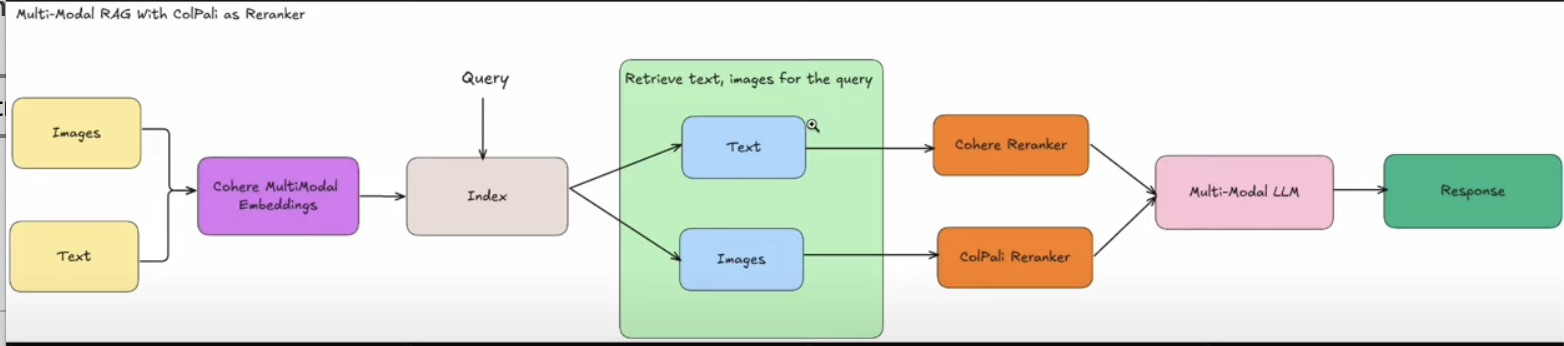

# Tools
1. ColPali VLM
2. Cohere Reranker
3. Cohere Embeddings
4. Llama-Index
5. gpt-4o LLM
6. Qdrant vector DB



# Install Dependencies

In [5]:
%%capture
!pip install llama-index

In [6]:
%%capture
!pip install llama-index-postprocessor-colpali-rerank

In [7]:
%pip install llama-index-postprocessor-cohere-rerank > /dev/null

In [8]:
# %%capture
# !pip install llama-index-postprocessor-cohere-rerank

In [9]:
%%capture
!pip install llama-index-embeddings-cohere

In [10]:
%%capture
!pip install llama-index-vector-stores-qdrant
!pip install llama-index-multi-modal-llms-openai

In [11]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests

## other imports
from PIL import Image
import urllib.request
from pathlib import Path

# Setup API Keys and Environment Variables
* Setup Cohere API key
* Setup OpenAI API key

In [12]:
import os
from getpass import getpass

## cohere
COHERE_API_KEY = getpass("Enter your COHERE API KEY: ")

Enter your COHERE API KEY: ··········


In [13]:
## cohere -- set env variable
os.environ['COHERE_API_KEY'] = COHERE_API_KEY

In [14]:
## OpenAI API key

OPENAI_API_KEY = getpass("Enter your OPENAI API KEY: ")

Enter your OPENAI API KEY: ··········


In [15]:
## OPENAI -- set env variable

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Helper Functions
* `get_wiki_images`
  * get image URLs from Wikipedia page with specific title.

* `plot_images`
  * plot images in specified image paths.

* `delete_large_images`
  * deletes images that are larger than 5 MB in directory.

* Cohere API only accepts images that are less than 5 MB in size.

In [16]:
## get wikipedia images function
def get_wiki_images(title):
  """
  Function to get image URLs from Wikipedia page based on title.
  """
  response = requests.get(
      "https://en.wikipedia.org/w/api.php",

      params={
          "action": "query",
          "format": "json",
          "titles": title,
          "prop": "imageinfo",
          "iiprop": "url|dimensions|mime",
          "generator": "images",
          "gimlimit": "50",
      },
  ).json()
  ## get image_urls
  image_urls = []
  for page in response["query"]["pages"].values():
    if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
        0
    ]["url"].endswith(".png"):
      image_urls.append(page["imageinfo"][0]["url"])
  return image_urls


## plot images function
def plot_images(image_paths):
  """
  Function to plot images based on specific list if image paths.
  """
  images_shown=0
  plt.figure(figsize=(12,8))
  for img_path in image_paths:
    if os.path.isfile(img_path):
      image=Image.open(img_path)

      plt.subplot(2,3, images_shown + 1)
      plt.imshow(image)
      plt.xticks([])
      plt.yticks([])

      images_shown += 1
      if images_shown >= 9:
        break


## delete large images function
def delete_large_images(folder_path):
  """
  Function to delete images larger than 5 MB in directory.
  """
  ## store names of deleted image files in list
  deleted_images = []

  ## iteration through file directory
  for file_name in os.listdir(folder_path):
    if file_name.lower().endswith(
        (".png",".jpg",".jpeg",".gif",".bmp")
    ):
        # Build file path
        file_path = os.path.join(folder_path, file_name)
        # get size of file in bytes
        file_size = os.path.getsize(file_path)
        # check if file size > 5 MB or 5242880 bytes and remove
        if file_size > 5242880:
          os.remove(file_path)
          deleted_images.append(file_name)
          print(f"Image: {file_name} was larger than 5 MB and is now deleted.")

# Get Text and Images from Wikipedia
* These are the wikipedia pages:

1. Ferrari Testarossa
2. Jeep Grand Cherokee
3. Subaru Outback

In [17]:
import requests
from pathlib import Path
import urllib.request

def get_wiki_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "images",
            "imlimit": "max"
        },
    ).json()

    page = next(iter(response['query']['pages'].values()))
    if 'images' not in page:
        return []

    image_titles = [img['title'] for img in page['images']]

    image_urls = []
    for img_title in image_titles:
        img_response = requests.get(
            "https://en.wikipedia.org/w/api.php",
            params={
                "action": "query",
                "format": "json",
                "titles": img_title,
                "prop": "imageinfo",
                "iiprop": "url"
            },
        ).json()

        img_page = next(iter(img_response['query']['pages'].values()))
        if 'imageinfo' in img_page:
            image_urls.append(img_page['imageinfo'][0]['url'])

    return image_urls

image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 10

wiki_titles = {
    "Ferrari Testarossa",
    "Jeep Grand Cherokee",
    "Subaru Outback"
}
data_path = Path("mixed_wiki")
if not data_path.exists():
    data_path.mkdir()

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response['query']['pages'].values()))
    wiki_text = page['extract']

    with open(data_path / f"{title}.txt", "w", encoding="utf-8") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        list_img_urls = get_wiki_images(title)

        for url in list_img_urls:
            if url.lower().endswith((".jpg", ".png", ".svg")):
                image_uuid += 1
                file_name = f"{image_uuid}.jpg"
                file_path = data_path / file_name
                urllib.request.urlretrieve(url, file_path)
                image_metadata_dict[image_uuid] = {
                    "filename": file_name,
                    "path": str(file_path)
                }
                images_per_wiki += 1
                if images_per_wiki >= MAX_IMAGES_PER_WIKI:
                    break
    except Exception as e:
        print(f"Error retrieving images for Wikipedia page: {title}")
        print(f"Error message: {str(e)}")
        continue

print(f"Total images downloaded: {image_uuid}")
print("Image metadata:")
print(image_metadata_dict)

Total images downloaded: 30
Image metadata:
{1: {'filename': '1.jpg', 'path': 'mixed_wiki/1.jpg'}, 2: {'filename': '2.jpg', 'path': 'mixed_wiki/2.jpg'}, 3: {'filename': '3.jpg', 'path': 'mixed_wiki/3.jpg'}, 4: {'filename': '4.jpg', 'path': 'mixed_wiki/4.jpg'}, 5: {'filename': '5.jpg', 'path': 'mixed_wiki/5.jpg'}, 6: {'filename': '6.jpg', 'path': 'mixed_wiki/6.jpg'}, 7: {'filename': '7.jpg', 'path': 'mixed_wiki/7.jpg'}, 8: {'filename': '8.jpg', 'path': 'mixed_wiki/8.jpg'}, 9: {'filename': '9.jpg', 'path': 'mixed_wiki/9.jpg'}, 10: {'filename': '10.jpg', 'path': 'mixed_wiki/10.jpg'}, 11: {'filename': '11.jpg', 'path': 'mixed_wiki/11.jpg'}, 12: {'filename': '12.jpg', 'path': 'mixed_wiki/12.jpg'}, 13: {'filename': '13.jpg', 'path': 'mixed_wiki/13.jpg'}, 14: {'filename': '14.jpg', 'path': 'mixed_wiki/14.jpg'}, 15: {'filename': '15.jpg', 'path': 'mixed_wiki/15.jpg'}, 16: {'filename': '16.jpg', 'path': 'mixed_wiki/16.jpg'}, 17: {'filename': '17.jpg', 'path': 'mixed_wiki/17.jpg'}, 18: {'filenam

# Delete Larger Image Files
* The Cohere Multimodal embedding model accepts less than 5 MB so we will delete the larger image files.

In [18]:
## delete large images
delete_large_images(data_path)

Image: 4.jpg was larger than 5 MB and is now deleted.
Image: 6.jpg was larger than 5 MB and is now deleted.
Image: 18.jpg was larger than 5 MB and is now deleted.
Image: 5.jpg was larger than 5 MB and is now deleted.
Image: 16.jpg was larger than 5 MB and is now deleted.
Image: 12.jpg was larger than 5 MB and is now deleted.
Image: 1.jpg was larger than 5 MB and is now deleted.


# Embedding Model and LLM Setup
1. Setup Cohere Multimodal embedding model for retrieval pipeline.
  * See the Cohere blog post: https://cohere.com/blog/introducing-embed-v3

2. Setup OpenAI Multimodal LLM for response generation pipeline.

In [19]:
## imports
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import Settings

## setup Cohere embedding model
Settings.embed_model = CohereEmbedding(
    api_key=COHERE_API_KEY,
    model_name="embed-english-v3.0", ## v3 models support multimodal embeddings
)

## setup GPT-4o model
gpt_llm = OpenAIMultiModal(model="gpt-4o",
                       max_new_tokens=4096)

# Cohere Reranker Setup
* See docs here: https://docs.llamaindex.ai/en/stable/examples/node_postprocessor/CohereRerank/

In [20]:
from llama_index.postprocessor.cohere_rerank import CohereRerank

## setup reranker model
cohere_rerank = CohereRerank(api_key=COHERE_API_KEY,
                             top_n=3) ## change top_n based on your data

# ColPali Reranker Setup

In [21]:
from llama_index.postprocessor.colpali_rerank import ColPaliRerank

## setup colpali reranker
colpali_reranker = ColPaliRerank(
    top_n=3,
    model="vidore/colpali-v1.2",
    keep_retrieval_score=True,
    device="cuda", # "mps" for Apple Mac, or "cuda" if on colab
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Load Data

In [22]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("/content/mixed_wiki").load_data()

Failed to load file /content/mixed_wiki/15.jpg with error: cannot identify image file '/content/mixed_wiki/15.jpg'. Skipping...


# Qdrant Vector Database Setup
* Qdrant vector database is what we can use to store text and image embeddings and metadata.

In [24]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
import qdrant_client

## init Qdrant vector database
client = qdrant_client.QdrantClient(path="qdrant_multi_db")

## create text vector store
text_vectors = QdrantVectorStore(
    client=client,
    collection_name="text_collection",
)
image_vectors = QdrantVectorStore(
    client=client,
    collection_name="image_collection",
)
storage_context = StorageContext.from_defaults(
    vector_store=text_vectors,
    image_store=image_vectors,
)

# Build MultiModalVectorStoreIndex
* Create the Multimodal vector store.

In [25]:
## create index
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import Settings # Import the Settings object from LlamaIndex

#Configure Settings object
Settings.embed_model = CohereEmbedding(
    api_key=COHERE_API_KEY,
    model_name="embed-english-v3.0", ## v3 models support multimodal embeddings
)

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    image_embed_model=Settings.embed_model,
)

/usr/local/lib/python3.11/dist-packages/llama_index/vector_stores/qdrant/base.py:703: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


# Test Retriever
* Create retriever object and test it out.

In [26]:
## setup retriever engine
retriever_engine = index.as_retriever(
    similarity_top_k=6,
    image_similarity_top_k=6
)

In [27]:
## test query
query = "What type of Jeeps are discussed?"
retrieval_results = retriever_engine.retrieve(query)

# View Retrieval Results from MultiModal Query


**Node ID:** dd42cec6-f11d-4545-a61e-01d45d4baabe<br>**Similarity:** 0.5379083006734248<br>**Text:** The Jeep Grand Cherokee is a range of mid-sized sport utility vehicles produced by American manufacturer Jeep. At its introduction, while most SUVs were still manufactured with body-on-frame constr...<br>

**Node ID:** f01d1527-a2b2-466f-8e13-531cd72d167d<br>**Similarity:** 0.5104153410025286<br>**Text:** (Must purchase new PCM and ABS module and program them with a fake VIN to make this work.) The 42RE 4-speed automatic remained the transmission for the inline 6 engine. It had slight changes from t...<br>

**Node ID:** 534a582d-b9a1-44e9-9357-832a851b9db4<br>**Similarity:** 0.48602459752651994<br>**Text:** == First generation (ZJ; 1993) ==

The original Grand Cherokee was launched in 1992 as a 1993 model-year vehicle in the luxury SUV segment. The "ZJ" models, manufactured from 1992 until 1998, origi...<br>

**Node ID:** 07265490-4902-4893-845d-47cc935b5f00<br>**Similarity:** 0.4841319702764418<br>**Text:** === Safety ===


== Sales ==


== Recalls ==


=== Fuel system integrity ===
In 2010, the National Highway Traffic Safety Administration (NHTSA) launched an investigation into 1993–2004 model year ...<br>

**Node ID:** 5ace280b-bafd-4800-b5cc-a4d0cf1a0d50<br>**Similarity:** 0.4820496450907018<br>**Text:** === Engines ===


== Fourth generation (WK2; 2011) ==

The fourth-generation WK2 Grand Cherokee went on sale in summer 2010 as a 2011 model. It was unveiled at the 2009 New York Auto Show. In 2009,...<br>

**Node ID:** 59333f88-9933-4c3f-98ba-c0d2ef52602d<br>**Similarity:** 0.4631946874743416<br>**Text:** === Engines ===


=== Production numbers ===


== Second generation (WJ/WG; 1999) ==

Launched in September 1998, the redesigned WJ 1999 Grand Cherokee shared just 127 parts with its predecessor (m...<br>

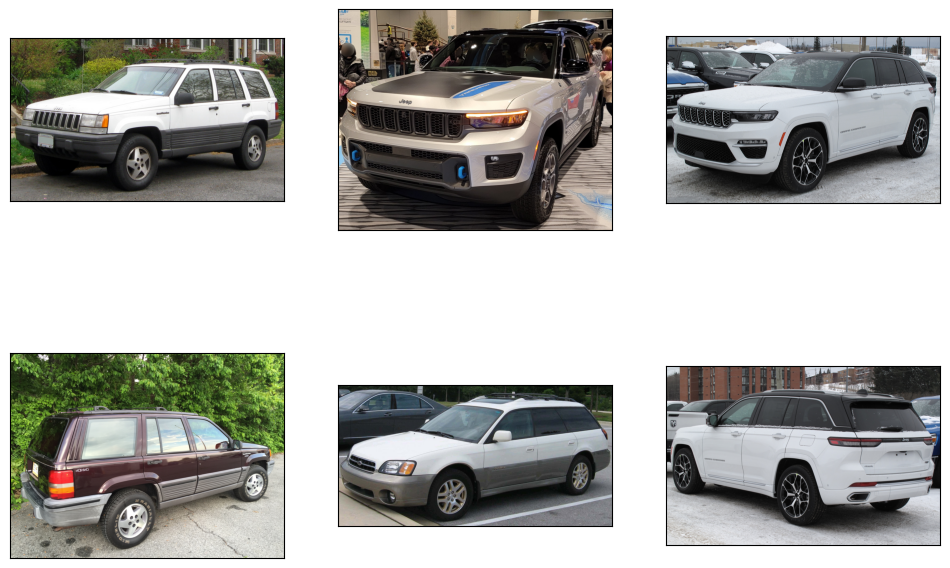

In [28]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)


## show images retrieved
plot_images(retrieved_image)

# Test the MultiModal QueryEngine
* Now we need to create a QueryEngine by using the above MultiModalVectorStoreIndex.

In [29]:
from llama_index.core.query_engine import (
    CustomQueryEngine,
    SimpleMultiModalQueryEngine,
)
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import (
    ImageNode,
    NodeWithScore,
    MetadataMode,
    TextNode,
)
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.core.indices.query.schema import QueryBundle
from typing import Optional

QA_PROMPT_TMPL = """\
Below we give parsed text and images as context.

Use both the parsed text and images to answer the question.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: OpenAIMultiModal

    def __init__(
        self, qa_prompt: Optional[PromptTemplate] = None, **kwargs
    ) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        image_nodes = [n for n in nodes if isinstance(n.node, ImageNode)]
        text_nodes = [n for n in nodes if isinstance(n.node, TextNode)]

        # Make QueryBundle
        query_bundle = QueryBundle(query_str)

        # reranking text nodes
        reranked_text_nodes = cohere_rerank.postprocess_nodes(
            text_nodes, query_bundle
        )

        # reranking image nodes
        reranked_image_nodes = colpali_reranker.postprocess_nodes(
            image_nodes, query_bundle
        )

        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [
                r.get_content(metadata_mode=MetadataMode.LLM)
                for r in reranked_text_nodes
            ]
        )
        fmt_prompt = self.qa_prompt.format(
            context_str=context_str, query_str=query_str
        )

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[n.node for n in reranked_image_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={
                "text_nodes": reranked_text_nodes,
                "image_nodes": reranked_image_nodes,
            },
        )

        return response

In [32]:
## init query engine
query_engine = MultimodalQueryEngine(
    retriever=retriever_engine,
    multi_modal_llm=gpt_llm,
)

In [33]:
## test query again
query = "What type of Jeeps are discussed?"
response = query_engine.query(query)

In [34]:
print(str(response))

The types of Jeeps discussed are the Jeep Grand Cherokee. This information is derived from the text, which provides detailed information about the Jeep Grand Cherokee's development, engines, safety, and recalls. The images also depict different models of the Jeep Grand Cherokee, confirming the type of Jeep being discussed. There are no discrepancies between the text and images.


# Get Source Documents

**Node ID:** 5ace280b-bafd-4800-b5cc-a4d0cf1a0d50<br>**Similarity:** 0.51552844<br>**Text:** === Engines ===


== Fourth generation (WK2; 2011) ==

The fourth-generation WK2 Grand Cherokee went on sale in summer 2010 as a 2011 model. It was unveiled at the 2009 New York Auto Show. In 2009,...<br>

**Node ID:** dd42cec6-f11d-4545-a61e-01d45d4baabe<br>**Similarity:** 0.47846788<br>**Text:** The Jeep Grand Cherokee is a range of mid-sized sport utility vehicles produced by American manufacturer Jeep. At its introduction, while most SUVs were still manufactured with body-on-frame constr...<br>

**Node ID:** 07265490-4902-4893-845d-47cc935b5f00<br>**Similarity:** 0.43986762<br>**Text:** === Safety ===


== Sales ==


== Recalls ==


=== Fuel system integrity ===
In 2010, the National Highway Traffic Safety Administration (NHTSA) launched an investigation into 1993–2004 model year ...<br>

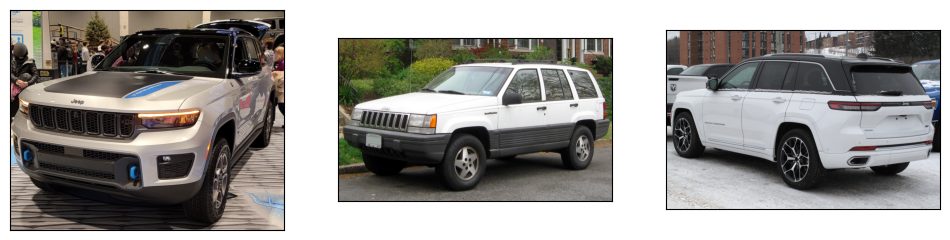

In [35]:
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)